# Importing packages

In [1]:
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

Using TensorFlow backend.
c:\users\aritra banerjee\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\aritra banerjee\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\aritra banerjee\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\aritra banerjee\envs\gpu\lib\site-packages\t

# Importing data

In [2]:
merchant_data = pd.read_csv(r'D:\Academics\CMI\Internship\Fortiate\DST-()_NN_count_prediction\Data\Merchant-Transactions-Jan21.csv', low_memory = False)
merchant_data.head()

,MHMID,ORIG_MSG_TYPE,TID,MHPAN,MHTXN_DATE,MHTXN_POST_DATE,MH_POS_TERM_CAPA,MH_POS_ENTRY_MODE,MH_TXN_AMOUNT,AMOUNT,MH_AUTH_CODE,MH_BATCH_NUM,MHGL_TYPE,MHARN_NUM,MHTXN_CURR
0,48845939.0,VISA PLATINUM,9036907,4.760000e+15,11-Feb-19,12-Feb-19,POS ICC,21,20000.0,20000.0,959442,462,8,7.480000e+22,INR
1,48845939.0,VISA PLATINUM,9036907,4.860000e+15,12-Feb-19,12-Feb-19,POS ICC,21,6960.0,6960.0,166833,462,8,7.480000e+22,INR
2,48845939.0,VISA.,9036907,4.170000e+15,12-Feb-19,12-Feb-19,POS ICC,51,27347.0,27347.0,7868,462,10,7.480000e+22,INR
3,48845939.0,MASTERCARD,9036907,5.900000e+15,12-Feb-19,12-Feb-19,POS ICC/MS/KE,51,26843.0,26843.0,194046,462,10,8.520000e+22,INR
4,48845939.0,MC PLATINUM,9036907,5.840000e+15,12-Feb-19,12-Feb-19,POS ICC/MS/KE,21,2057.0,2057.0,226937,462,7,8.520000e+22,INR


# Pre processing

Using merchant id (MHMID) to form different groups. Choosing those MHMID having more than 1000 data points and training seperate models for each merchant.

In [3]:
selected_merchants = []
for i in (merchant_data.MHMID.unique()):
    if (len(merchant_data[merchant_data.MHMID == i]) > 1000):
        selected_merchants.append(i)
#         selected_merchant.append([i, len(merchant_data[merchant_data.MHMID == i])])

In [4]:
selected_merchants

[48034757.0,
 48060376.0,
 48857338.0,
 48054469.0,
 48057390.0,
 48059439.0,
 48033377.0,
 48097703.0,
 48087997.0,
 48097794.0,
 48940787.0,
 48970699.0,
 48906090.0,
 48099678.0,
 48097846.0]

# Showing data

Plotting data for 15 merchant category

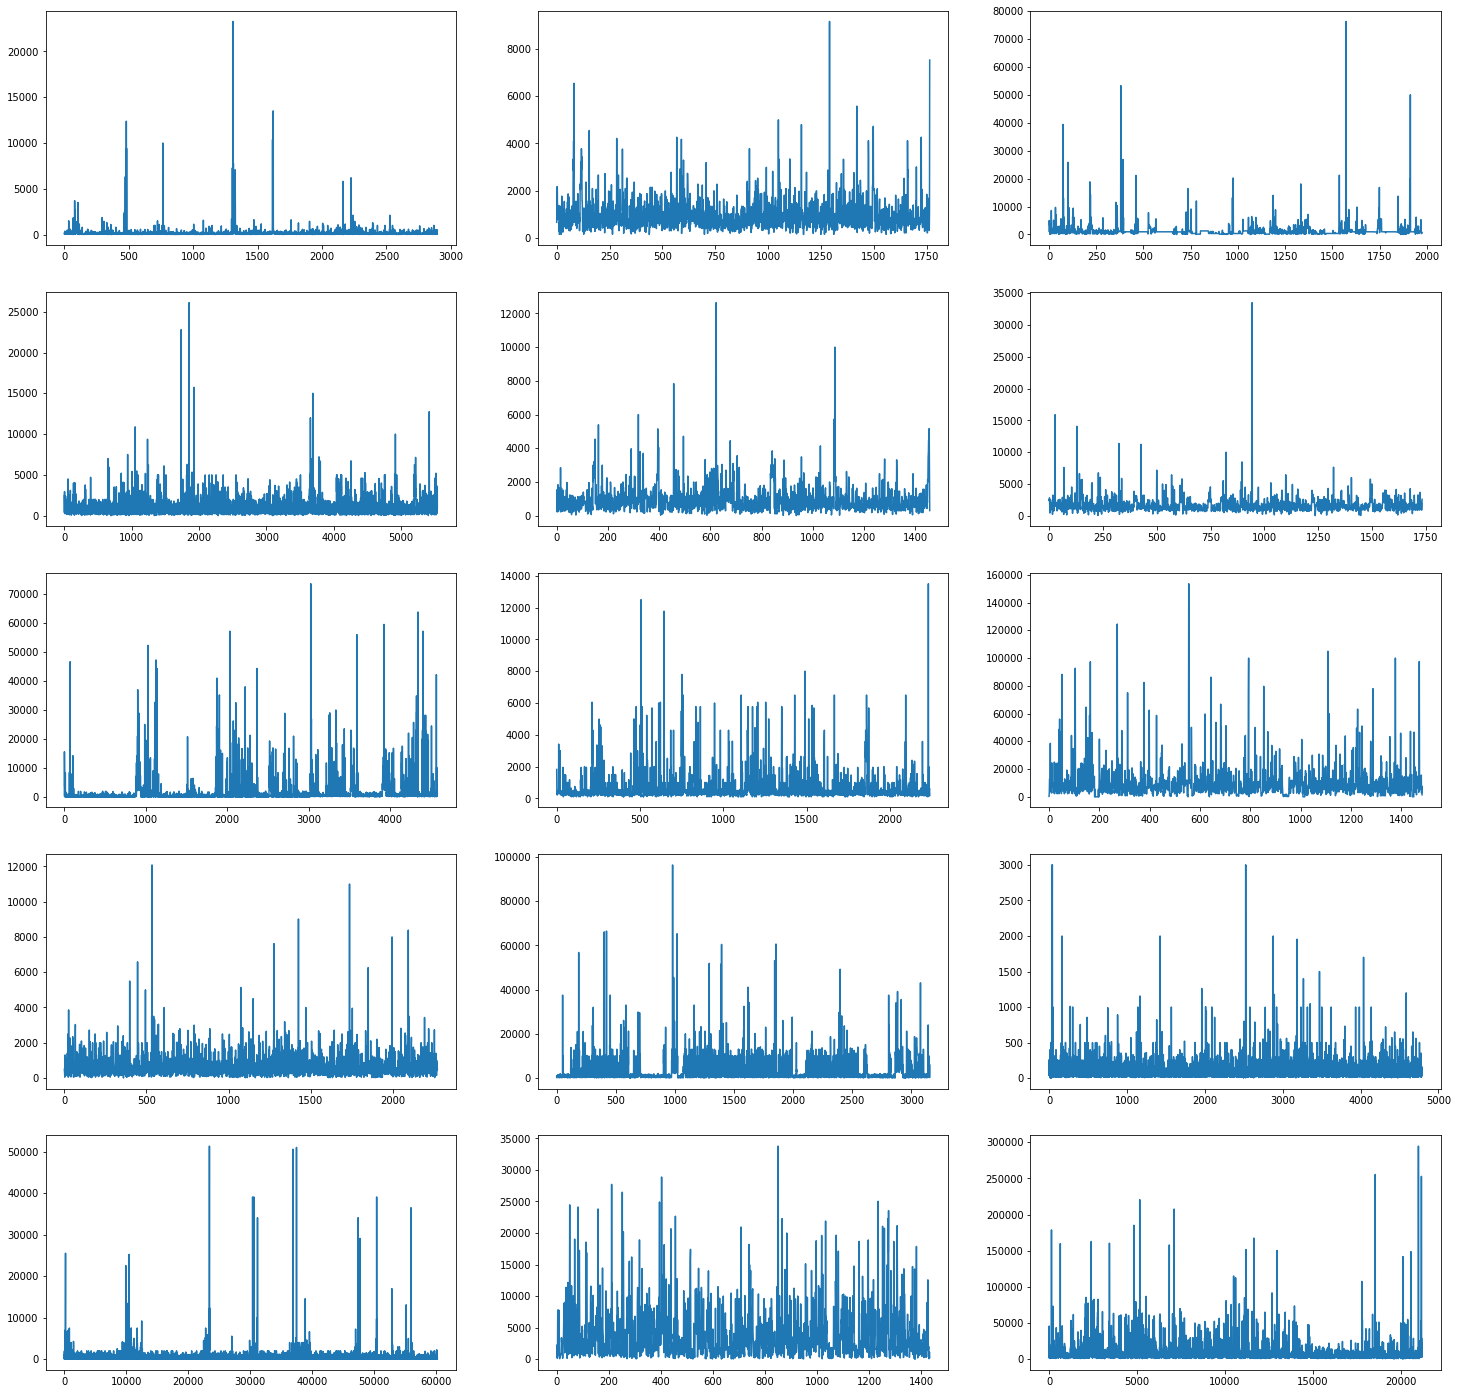

In [5]:
fig, ax = plt.subplots(5, 3, figsize=(25, 25))
x_ax = 0
y_ax = 0
for i in selected_merchants:
    data = merchant_data.AMOUNT[merchant_data.MHMID == i]
    length = len(data)
    ax[x_ax][y_ax].plot(list(range(0, length)), data)
    y_ax += 1
    if y_ax == 3:
        x_ax += 1
        y_ax = 0

# Function to fit model

In [6]:
def processing_dataset(data_temp):
    data_temp = np.array(data_temp)
    scaler = MinMaxScaler(feature_range = (0, 1))
    data_temp = data_temp.reshape(-1, 1)
    dataset = scaler.fit_transform(data_temp)
    return(dataset)

In [7]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [19]:
def fit_model(train_X, train_Y, window_size = 1, verbose = 1):
    model = Sequential()
    
    model.add(LSTM(6, input_shape = (1, window_size)))

    model.add(Dense(1))
    
    model.compile(loss = "mean_squared_error", optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 1,
              verbose = 1)
    
    
    return(model)

In [9]:
def predict_and_score(model, X, Y):
    scaler = MinMaxScaler(feature_range = (0, 1))
    
    # Make predictions on the original scale of the data.
    pred = model.predict(X)
    pred = list(pred.flatten())
    
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = list(Y)
    
#     print(list(zip(pred[:-1], orig_data[1:])))
    
    # Calculate RMSE.
#     score = math.sqrt(mean_squared_error(orig_data[1:], pred[:-1]))
    score = mean_squared_error(orig_data, pred)
    
    return(score)

# Modeling for merchants

Modeling for a perticular merchant

In [22]:
merchant = selected_merchants[0]
data = merchant_data.AMOUNT[merchant_data.MHMID == merchant]

In [23]:
data_len = len(data)
limit = (data_len * 70)//100
data = processing_dataset(data)
train_data = data[:limit]
test_data = data[limit:]

In [24]:
win_size = 50
train_x, train_y = create_dataset(train_data, window_size = win_size)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
model = fit_model(train_x, train_y, window_size = win_size)

Epoch 1/10
1976/1976 [==============================] - 12s 6ms/step - loss: 0.0017
Epoch 2/10
1976/1976 [==============================] - 9s 5ms/step - loss: 0.0015
Epoch 3/10
1976/1976 [==============================] - 11s 5ms/step - loss: 0.0015
Epoch 4/10
1976/1976 [==============================] - 11s 6ms/step - loss: 0.0014
Epoch 5/10
1976/1976 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 6/10
1976/1976 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 7/10
1976/1976 [==============================] - ETA: 0s - loss: 0.001 - 10s 5ms/step - loss: 0.0014
Epoch 8/10
1976/1976 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 9/10
1976/1976 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 10/10
1976/1976 [==============================] - 10s 5ms/step - loss: 0.0014


In [25]:
predict_and_score(model, train_x, train_y)

0.0013441409545793892

In [26]:
test_x, test_y = create_dataset(test_data, window_size = win_size)
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
predict_and_score(model, test_x, test_y)

0.00025647544611209896

For all merchant

In [15]:
for i in selected_merchants:
    merchant = i
    data = merchant_data.AMOUNT[merchant_data.MHMID == merchant]

    data_len = len(data)
    limit = (data_len * 70)//100
    data = processing_dataset(data)
    train_data = data[:limit]
    test_data = data[limit:]
    
    win_size = 50
    train_x, train_y = create_dataset(train_data, window_size = win_size)
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    model = fit_model(train_x, train_y, window_size = win_size, verbose = 0)
    
    test_x, test_y = create_dataset(test_data, window_size = win_size)
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    print("Test mse for merchant {} is {}" .format(i, predict_and_score(model, test_x, test_y)))

Test mse for merchant 48034757.0 is 0.0002502528416296357
Test mse for merchant 48060376.0 is 0.007287890526933282
Test mse for merchant 48857338.0 is 0.00330687651570343
Test mse for merchant 48054469.0 is 0.0012605371026337283
Test mse for merchant 48057390.0 is 0.004382642540406734
Test mse for merchant 48059439.0 is 0.0006297615130401267
Test mse for merchant 48033377.0 is 0.004965853966769232
Test mse for merchant 48097703.0 is 0.004378629562037878
Test mse for merchant 48087997.0 is 0.00718208743013308
Test mse for merchant 48097794.0 is 0.00534496610221925
Test mse for merchant 48940787.0 is 0.0027465614342487405
Test mse for merchant 48970699.0 is 0.00217749929787485
Test mse for merchant 48906090.0 is 0.00025441048353916465
Test mse for merchant 48099678.0 is 0.01883702009622983
Test mse for merchant 48097846.0 is 0.0006891121628447894
